### Importing libraries

In [99]:
# Importing data processing libraries
import pandas as pd
import numpy as np
import os

# importing visualization libraries
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
%matplotlib inline


import cv2 # open-cv used for image processing
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# importing neural network libraries
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Activation,Dropout,Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator # Keras image data generator is used for the generation

Defining the file path for training, testing csv and image files

In [23]:
train_dir = r'train'
test_dir = r'test'
train_csv = r'train.csv'
test_csv = r'test.csv'

image1 =  r'train\1.jpg'

Reading a single image from the directory

In [24]:
image = cv2.imread(image1) 
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # converting to RGB

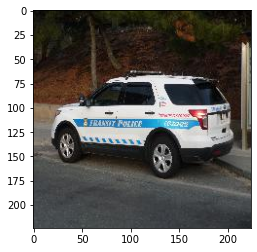

In [25]:
plt.imshow(image)

### Data preparation

### Generating images from dataframe

Creating dataframes for training and data csv files 

In [26]:
train_df=pd.read_csv(train_csv)
test_df=pd.read_csv(test_csv)

In [27]:
test_df.head()

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg


In [28]:
train_df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


Converting binary classification column to string

In [29]:
train_df['emergency_or_not'] = train_df['emergency_or_not'].astype(str)

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   object
dtypes: object(2)
memory usage: 25.8+ KB


Splitting the training dataset 80/20 for training and validation 

In [31]:
idx = int(len(train_df) - len(train_df) * 0.2)
val_df = train_df[idx:]
train_df = train_df[:idx]

print(f'Training Dataset: {len(train_df)} images\nValidation Dataset: {len(val_df)} images')

Training Dataset: 1316 images
Validation Dataset: 330 images


### Creating an Image generator

In [32]:
image_shape = image.shape # This shows the shape of the image (length, width, channel)
image_shape

(224, 224, 3)

In [33]:
img_size = (224, 224) # assigning image size tuple to variable
batch_size = 10 # assigning batch size

In [34]:
# Here we are applying our desired transformations
image_gen = ImageDataGenerator(
                                rotation_range=20,# specifies the rotation to be 20%
                                width_shift_range=0.1, # specifies the width shift of 10%
                                height_shift_range=0.1,# specifies the height shift of 10%
                                shear_range=0.20, # crops part of the image
                                zoom_range=0.20, # #zooms the image by 20%
                                fill_mode='nearest', # fills using the nearest pixel
                                horizontal_flip=True, # Secifies the horizontal flip
                                rescale=1/255 # scales the image
                                )

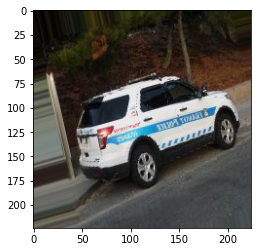

In [35]:
# showing the transformation
plt.imshow(image_gen.random_transform(image))

Instantiating a training generator from training dataframe

In [36]:
train_generator = image_gen.flow_from_dataframe(dataframe=train_df, # specify the dataset used for training
                                                directory = train_dir, # specify the path to the directory
                                                x_col='image_names', # specify the names of the images
                                                y_col='emergency_or_not', # specifies the class labels
                                                class_mode='binary', # specifies the kind of classification
                                                target_size=img_size, # specifies the dimension to resize the im
                                                batch_size=batch_size, # defines the batch size
                                                color_mode='rgb'
                                                )

Found 1316 validated image filenames belonging to 2 classes.


Instantiating a validation generator from validation dataframe

In [37]:
validation_generator = image_gen.flow_from_dataframe(dataframe=val_df, # specify the dataset used for training
                                                    directory = train_dir, # specify the path to the directory
                                                    x_col='image_names', # specify the names of the images
                                                    y_col='emergency_or_not', # specifies the class labels
                                                    class_mode='binary', # specifies the kind of classification
                                                    target_size=img_size, # specifies the dimension to resize the im
                                                    batch_size = batch_size, # defines the batch size
                                                    shuffle = False, # to preserve order
                                                    color_mode='rgb'
                                                    ) 

Found 330 validated image filenames belonging to 2 classes.


### Creating the CNN model

## Model 1: 2 layer architecture

First model is made up of 2 convolutional layers, 2 dense layers, 1 pooling layer, 1 flatten layer and 1 dropout layer, making a total of 7 layers

In [84]:
model_2 = Sequential()

model_2.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=image_shape, activation = 'relu', padding = 'same'))
model_2.add(Conv2D(filters=32,kernel_size=(3,3), activation = 'relu', padding = 'same'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Flatten())

model_2.add(Dense(64,activation = 'relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(1,activation = 'sigmoid'))

In [85]:
model_2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [86]:
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_44 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 401408)            0         
                                                                 
 dense_21 (Dense)            (None, 64)                25690176  
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                     

### Training the model_2

In [87]:
history = model_2.fit(train_generator, epochs = 10, validation_data = validation_generator)

Epoch 1/10
132/132 [==============================] - 126s 933ms/step - loss: 0.9724 - accuracy: 0.6254 - val_loss: 0.6671 - val_accuracy: 0.6273
Epoch 2/10
132/132 [==============================] - 116s 875ms/step - loss: 0.6434 - accuracy: 0.6497 - val_loss: 0.6492 - val_accuracy: 0.6909
Epoch 3/10
132/132 [==============================] - 115s 872ms/step - loss: 0.6115 - accuracy: 0.6877 - val_loss: 0.5712 - val_accuracy: 0.7182
Epoch 4/10
132/132 [==============================] - 120s 909ms/step - loss: 0.5723 - accuracy: 0.7318 - val_loss: 0.4985 - val_accuracy: 0.7515
Epoch 5/10
132/132 [==============================] - 121s 916ms/step - loss: 0.5565 - accuracy: 0.7439 - val_loss: 0.4397 - val_accuracy: 0.8030
Epoch 6/10
132/132 [==============================] - 124s 940ms/step - loss: 0.5387 - accuracy: 0.7538 - val_loss: 0.4825 - val_accuracy: 0.7758
Epoch 7/10
132/132 [==============================] - 125s 950ms/step - loss: 0.5410 - accuracy: 0.7515 - val_loss: 0.5121 -

### Evaluating the model_2

In [88]:
model_2.evaluate(validation_generator)

33/33 [==============================] - 5s 162ms/step - loss: 0.4386 - accuracy: 0.7848


[0.43862712383270264, 0.7848485112190247]

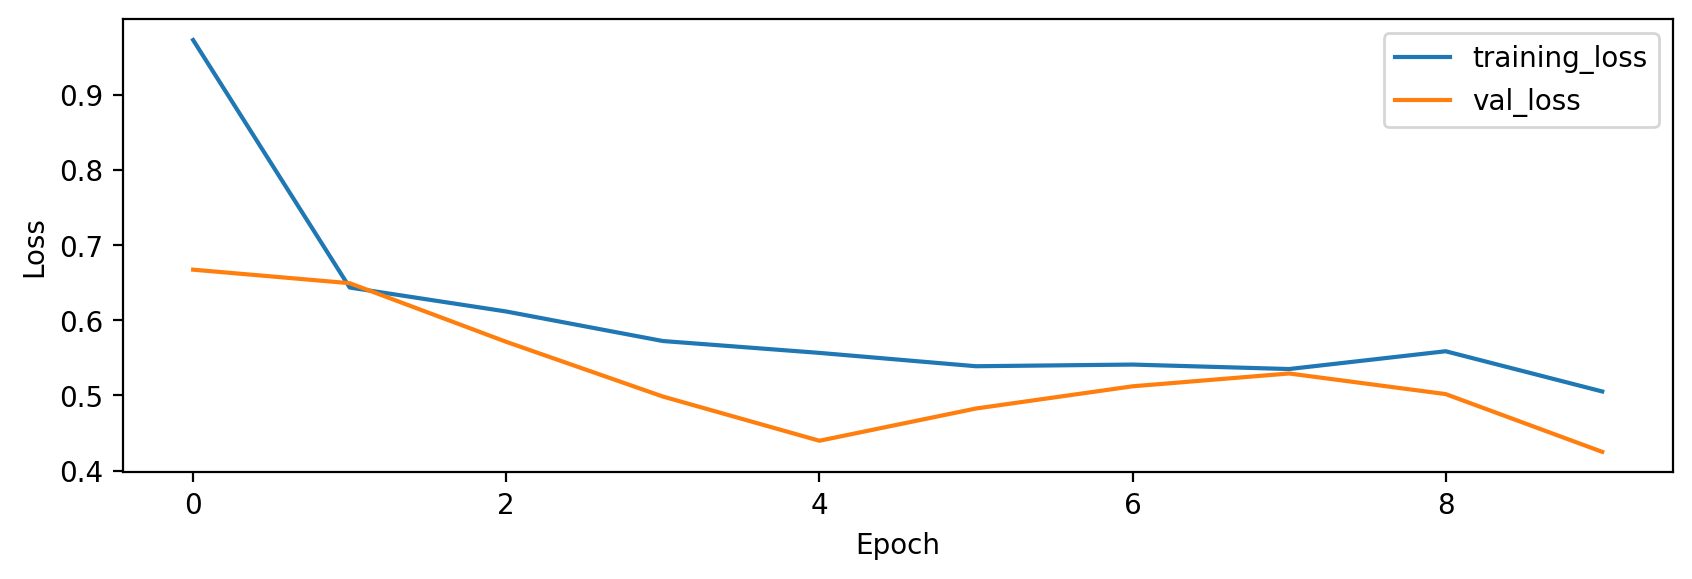

In [89]:
## checking for overfitting
history_df = pd.DataFrame(history.history)
plt.figure(dpi=200, figsize = (10,3))
plt.plot(history_df['loss'],label='training_loss')
plt.plot(history_df['val_loss'],label='val_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


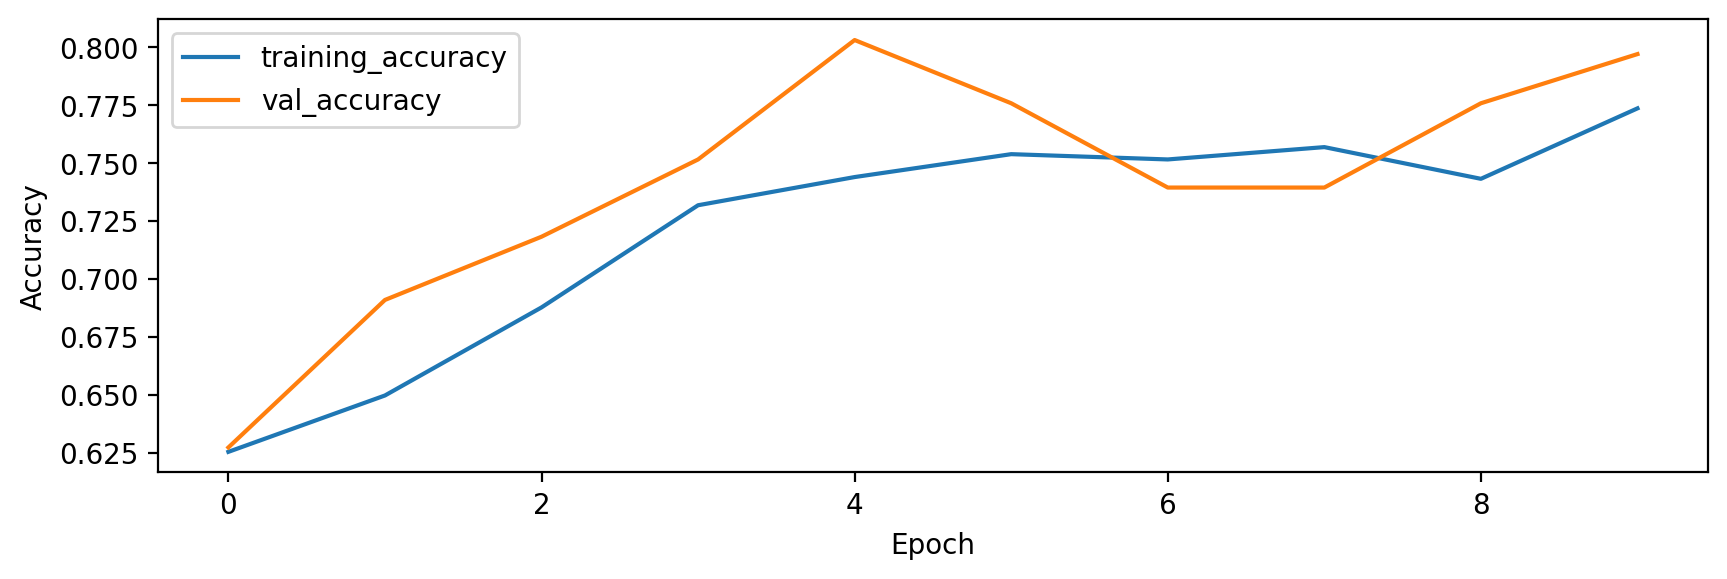

In [90]:
## checking for overfitting
history_df = pd.DataFrame(history.history)
plt.figure(dpi=200, figsize = (10,3))
plt.plot(history_df['accuracy'],label='training_accuracy')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## Model 2: 4 layer architecture

Second model is made up of 4 convolutional layers, 2 dense layers, 2 pooling layer, 1 flatten layer and 1 dropout layer, making a total of 7 layers. Making a total of 10 layers

In [63]:
model_4 = Sequential()

model_4.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=image_shape, activation = 'relu', padding = 'same'))
model_4.add(Conv2D(filters=32,kernel_size=(3,3), activation = 'relu', padding = 'same'))
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Conv2D(filters=64,kernel_size=(3,3), activation = 'relu', padding = 'same'))
model_4.add(Conv2D(filters=64,kernel_size=(3,3), activation = 'relu', padding = 'same'))
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Flatten())

model_4.add(Dense(64,activation = 'relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(1,activation = 'sigmoid'))

In [64]:
model_4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [65]:
model_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_25 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                 

Implementing Early Stopping for this model_4

In [66]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

### Training the model_4

In [67]:
history = model_4.fit(train_generator, epochs = 10, validation_data = validation_generator, callbacks=[early_stop])

Epoch 1/10
132/132 [==============================] - 141s 1s/step - loss: 0.7204 - accuracy: 0.5790 - val_loss: 0.6750 - val_accuracy: 0.6515
Epoch 2/10
132/132 [==============================] - 138s 1s/step - loss: 0.6493 - accuracy: 0.6816 - val_loss: 0.5669 - val_accuracy: 0.7121
Epoch 3/10
132/132 [==============================] - 137s 1s/step - loss: 0.6086 - accuracy: 0.6968 - val_loss: 0.5438 - val_accuracy: 0.7606
Epoch 4/10
132/132 [==============================] - 138s 1s/step - loss: 0.5793 - accuracy: 0.7226 - val_loss: 0.5384 - val_accuracy: 0.7333
Epoch 5/10
132/132 [==============================] - 137s 1s/step - loss: 0.5326 - accuracy: 0.7538 - val_loss: 0.5609 - val_accuracy: 0.7091
Epoch 6/10
132/132 [==============================] - 138s 1s/step - loss: 0.5507 - accuracy: 0.7204 - val_loss: 0.4929 - val_accuracy: 0.7576
Epoch 7/10
132/132 [==============================] - 138s 1s/step - loss: 0.5372 - accuracy: 0.7340 - val_loss: 0.5139 - val_accuracy: 0.7364

### Evaluating the model_4

In [68]:
model_4.evaluate(validation_generator)

33/33 [==============================] - 7s 199ms/step - loss: 0.5070 - accuracy: 0.7818


[0.5070273876190186, 0.7818182110786438]

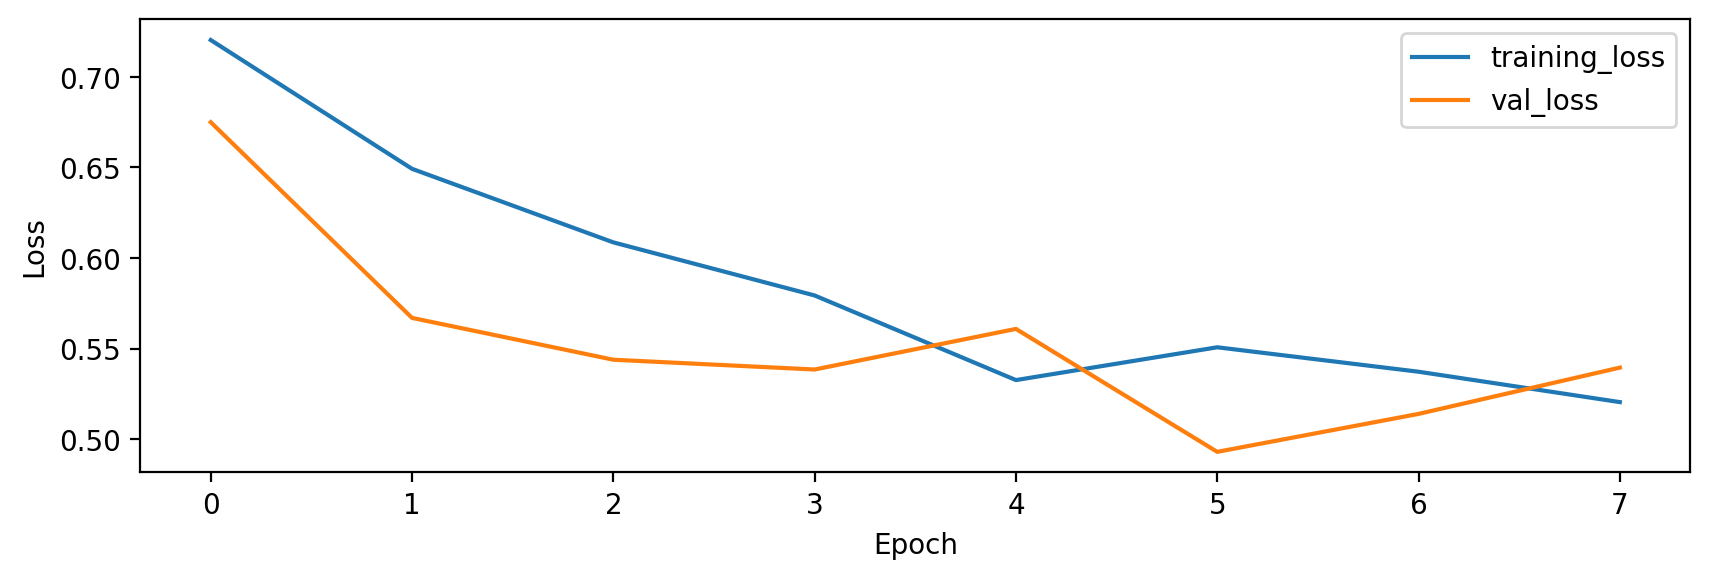

In [69]:
## checking for overfitting
history_df = pd.DataFrame(history.history)
plt.figure(dpi=200, figsize = (10,3))
plt.plot(history_df['loss'],label='training_loss')
plt.plot(history_df['val_loss'],label='val_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


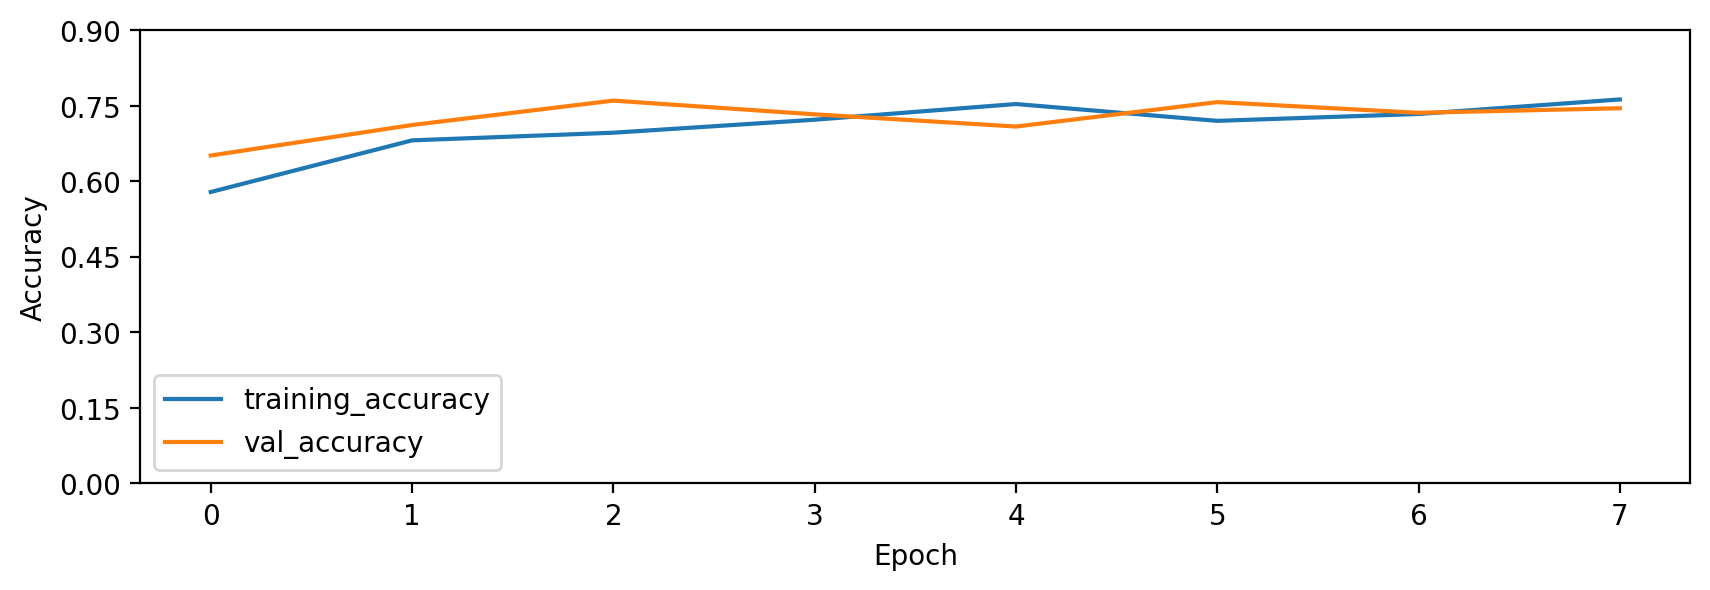

In [70]:
## checking for overfitting
history_df = pd.DataFrame(history.history)
plt.figure(dpi=200, figsize = (10,3))
plt.plot(history_df['accuracy'],label='training_accuracy')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## Model 3: Using VGG16 Based model

In [77]:
model_vgg = Sequential()

model_vgg.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_vgg.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_vgg.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_vgg.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_vgg.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_vgg.add(Flatten())
model_vgg.add(Dense(units=128,activation="relu"))
model_vgg.add(Dense(units=64,activation="relu"))
model_vgg.add(Dropout(0.2))
model_vgg.add(Dense(units=1, activation="sigmoid"))


In [78]:
model_vgg.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [79]:
model_vgg.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_31 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_33 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                

In [80]:
history = model_vgg.fit(train_generator, epochs = 10, validation_data = validation_generator, callbacks=[early_stop])

Epoch 1/10
132/132 [==============================] - 685s 5s/step - loss: 0.6956 - accuracy: 0.5745 - val_loss: 0.6673 - val_accuracy: 0.6212
Epoch 2/10
132/132 [==============================] - 697s 5s/step - loss: 0.6834 - accuracy: 0.5775 - val_loss: 0.6758 - val_accuracy: 0.6212
Epoch 3/10
132/132 [==============================] - 1169s 9s/step - loss: 0.6824 - accuracy: 0.5775 - val_loss: 0.6649 - val_accuracy: 0.6212
Epoch 4/10
132/132 [==============================] - 1189s 9s/step - loss: 0.6837 - accuracy: 0.5775 - val_loss: 0.6706 - val_accuracy: 0.6212
Epoch 5/10
132/132 [==============================] - 1090s 8s/step - loss: 0.6818 - accuracy: 0.5775 - val_loss: 0.6686 - val_accuracy: 0.6212


### Evaluating the model_vgg

In [81]:
model_vgg.evaluate(validation_generator)

33/33 [==============================] - 39s 1s/step - loss: 0.6686 - accuracy: 0.6212


[0.6685836911201477, 0.6212121248245239]

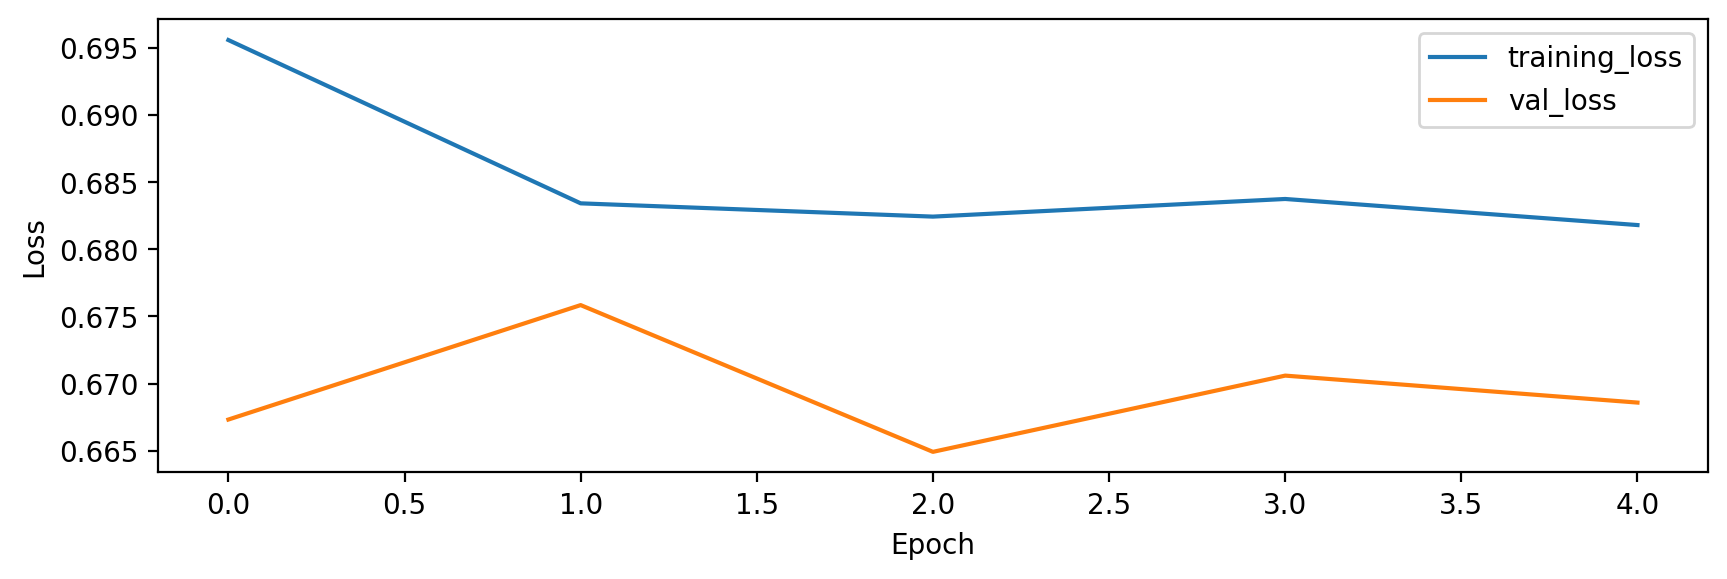

In [82]:
## checking for overfitting
history_df = pd.DataFrame(history.history)
plt.figure(dpi=200, figsize = (10,3))
plt.plot(history_df['loss'],label='training_loss')
plt.plot(history_df['val_loss'],label='val_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


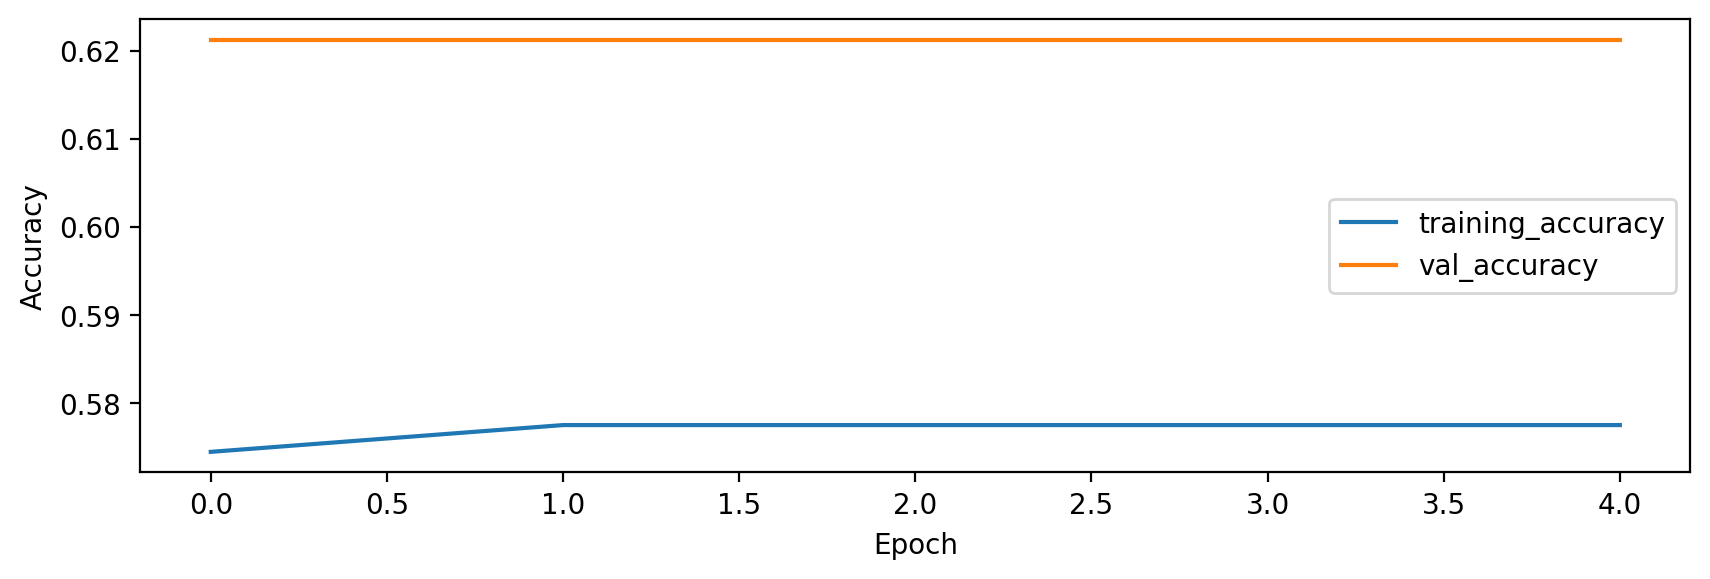

In [83]:
## checking for overfitting
history_df = pd.DataFrame(history.history)
plt.figure(dpi=200, figsize = (10,3))
plt.plot(history_df['accuracy'],label='training_accuracy')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## Predicting Validation Data

In [91]:
pred_probabilities = model_2.predict(validation_generator)

33/33 [==============================] - 6s 148ms/step


The code below is very crucial to the outcome of the model. A small change could lead to very poor performance

In [92]:
predictions = pred_probabilities > 0.5

In [94]:
print(classification_report(validation_generator.classes, predictions))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       205
           1       0.79      0.68      0.73       125

    accuracy                           0.81       330
   macro avg       0.80      0.78      0.79       330
weighted avg       0.81      0.81      0.81       330



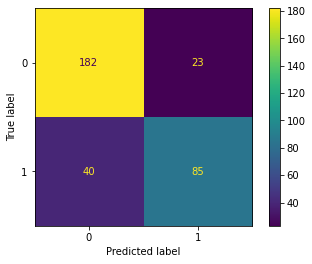

In [100]:
cm = confusion_matrix(validation_generator.classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()
plt.show()

## Saving model_2

In [103]:
model_2.save('vehicle_model.h5')

## Predicting Test Data

In [139]:
test_generator = image_gen.flow_from_dataframe(dataframe=test_df, # specify the dataset used for training
                                                directory=test_dir, # specify the path to the directory
                                                x_col='image_names', # specify the names of the images
                                                y_col='emergency_or_not', # specifies the class labels
                                                class_mode=None, # specifies the kind of classification
                                                target_size=img_size, # specifies the dimension to resize the im
                                                batch_size=batch_size, # defines the batch size
                                                shuffle = False, # to preserve order
                                                color_mode='rgb'
                                                )

Found 706 validated image filenames.


In [140]:
test_generator.reset()
pred_probabilities = model_2.predict(test_generator)

71/71 [==============================] - 11s 156ms/step


In [141]:
predicted_class_indices=np.argmax(pred_probabilities,axis=1)

In [142]:
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [150]:
predictions = pred_probabilities > 0.5 # 50% chance then true

In [151]:
predictions = predictions.tolist()
predictions = ['0' if i == False else '1' for inner_list in predictions for i in inner_list]

In [152]:
filenames = test_generator.filenames

result = pd.DataFrame({"image_name":filenames, "emergency_or_not":predictions})
result.to_csv("results.csv",index=False)